In [ ]:
''' Make a report of payloads delivered with log4j http gets.
    See search_log4j_payload.py
'''

import base64
import csv
import pandas as pd
import numpy as np
import pprint
import urllib.request, urllib.parse, urllib.error
import httplib2
import getpass
import sys
from time import sleep
import splunklib.results as results
import splunklib.client as client
import re

def defang_host(str):
    return re.sub(r"(https?:\/\/)([^\/]+)", r"\1?\2", str)

def defang_ip(str):
    return re.sub(r"((?:(?:[0-9]{1,3})(?:\.)?){4})", r"?\1", str)

def defang(str):
    fang = lambda p, s: re.sub(f"{p}", r"?\1", s)
    try:
        if type(str) == str:
            if len(str) == 0:
                return str
        if type(str) == float:
            if np.isnan(str):
                return str
        r = defang_ip( defang_host( fang("(wget|curl|bash|http)", str) ) )       
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        import pdb; pdb.set_trace()
    return r

def quote_words(str):
    '''quote_words("word1 word2") --> "word1",:word2
       Change string of words into string in quoted csv format
    '''
    return ",".join([ f'"{x}"' for x in str.replace("\n","").split()])

def build_query():
    # Build a query
    # Reminder: earliest_time = "12/13/2021:00:00:00"
    
    earliest_time = "12/14/2021:00:00:00"
    latest_time ="12/26/2021:00:00:00"

    idx = """directory_services_nonprod doh_google_cloud dol_google_cloud dtf_http estreamer
    fireeye hcr_google_cloud health_datapower health_network its_google_cloud its_okta
    nonprod main miauditlogs os otda_google_cloud vmware webny webny_nonprod wineventlog"""

    indexes = f"index IN ({quote_words(idx)})"

    match = '''Base64 Command "${jndi:*}"'''

    rex = '''| rex max_match=5 
    "({jndi.*?Base64\/(?<b64>(?:[A-Za-z0-9+\/]{4})*(?:[A-Za-z0-9+\/]{2}==|[A-Za-z0-9+\/]{3}=)?))"'''

#     rex = '''| rex "\${jndi.*?Base64\/(?<b64>[^}]*?)}.*"'''

    stats = '''
    | mvexpand b64 | stats values(host) as host earliest(_time) as earliest  by b64 |  mvexpand host 
    | convert timeformat="%m/%d/%Y %H:%M:%S" ctime(earliest) as earliest 
    | sort host +earliest 
    | table host earliest b64'''

    query = f"""search earliest={earliest_time}
                latest={latest_time} 
                {indexes} {match} {rex} {stats}"""

    return query

def d64(x):
    ''' d(b64)-->decodes base64 byte string. =Nan if there's an error
    '''
    try:
        r = base64.b64decode(x, altchars="-_").decode()
    except:
        r = np.nan
    return r

def make_list(events):
    '''make_list(events)-->list of the splunk events
    ''' 
    lst = []
    for result in results.ResultsReader(events):
        lst.extend(result.values())
    return lst

def list_to_df(lst, columns):
    '''Create a df with n=len(columns) columns from alist
       0th row has items lst[0] lst[1] ... (n-1)th
       lst row has items lst[0+n] lst[1+n] ... lst[(n-1 + n)i
       ... etc
    '''
    num_columns = len(columns)
    len_list    = len(lst)
    
    # Make sure t
    if len_list % num_columns != 0:
        print(f"length of lst ({len_list}) must be even multiple of # of names ({num_columns})")
        return None
    
    # Reshape the list into a list of lists before returning the dataframe
    sublists = [ lst[i:i+num_columns] for i in range(0, len_list, num_columns) ]
    return pd.DataFrame(sublists, columns=columns)

# This job makes a real search and outputs the result.

HOST = "cnsesplunkoperations.svc.ny.gov"
PORT = 8089
USERNAME = "bdk01"
PASSWORD = getpass.getpass()
OWNER = "bdk01"
APP = "search"

# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    owner=OWNER,
    app=APP)

# pp.pprint(query)

kwargs_normalsearch = {
#     "earliest_time": "12/09/2021:00:00:00",
#     "latest_time": "-1d@d",
    "search_mode": "normal"
    }
searchquery_normal = build_query()

job = service.jobs.create(searchquery_normal, **kwargs_normalsearch)

# A normal search returns the job's SID right away, so we need to poll for completion
while True:
    while not job.is_ready():
        pass
    stats = {"isDone": job["isDone"],
             "doneProgress": float(job["doneProgress"])*100,
              "scanCount": int(job["scanCount"]),
              "eventCount": int(job["eventCount"]),
              "resultCount": int(job["resultCount"])}

    status = ("\r%(doneProgress)03.1f%%   %(scanCount)d scanned   "
              "%(eventCount)d matched   %(resultCount)d results") % stats

    print(f"{status=}")
    sys.stdout.flush()
    if stats["isDone"] == "1":
        sys.stdout.write("\n\nDone!\n\n")
        break
    sleep(2)

# Get the results and display them
# for result in results.ResultsReader(job.results()):
#     print(result)

# By default only 100 events are returned. Use count=0 to get all of them to sys limit.
# See: Splunk Answer 308505
# https://community.splunk.com/t5/Splunk-Search/Custom-Splunk-search-command-only-returns-100-results/m-p/308505
    
# save_results = job.results()
save_results = job.results(count=0)

lst = make_list(save_results)
log = list_to_df(lst, columns=["host", "earliest", "base64_payload"])

# Decode the b64 column into new column, payload
defanging = False
if defanging:
    log["raw_payload"] = log.loc[:,"base64_payload"].apply(d64)
    # Defang the raw_payload column into new column, payload
    log["payload"] = log.loc[:,"raw_payload"].apply(defang)
else:
    log["payload"] = log.loc[:,"base64_payload"].apply(d64)

log[["host", "earliest", "payload"]].to_csv("search_log4j.txt", index=False)

job.cancel()   
sys.stdout.write('\n')



In [ ]:
%%python - "search_log4j.txt"
''' Read report of web payload's and get list of unique source hosts.'''
import re
import pandas as pd
import numpy as np
import sys

def fetch_ip(str):
    ''' fetch_ip(str)-->list of ip adresses in string
    '''
#     ippat = r"((?:[0-9]{1,3})\.(?:[0-9]{1,3})\.(?:[0-9]{1,3})\.(?:[0-9]{1,3}))"
    ippat = r"((?:(?:[0-9]{1,3})(?:\.)){3}(?:[0-9]{1,3}))"
    grp = re.findall(ippat, str)
    grp = [] if not grp else grp
    return grp

def fetch_host(cmd):
    httppat = r"https?:\/\/(?:\?*)([^\/:]+)(?:[\:\/])"
    grp = re.findall(httppat, cmd)
    r = [] if not grp else grp
    return r

def main():
    ''' Read report of web payload's and get list of unique source hosts '''

    # read the search results from the file supplied as an program argument
    fn = sys.argv[1]
    log = pd.read_csv(fn)

    # Clean up
    # Drop any rows that contain rm alalalNan. e.g. some of the web paylod's 
    # cannot be converted from base64
    log = log.dropna(subset=["payload"]).reset_index(drop=True)

    ## Find the hosts being referenced in the payload's

    hosts = {}

    grp = []
    for rec, cmd in enumerate(log.payload):
        r1 = [f"{x}" for x in fetch_ip(cmd)]
        r2 = [f"{x}" for x in fetch_host(cmd)]
        
        grp.extend(r1)
        grp.extend(r2)

    # Deduplicate, make into a df, and output as csv
    hosts = set(grp)

    # Store to host in column named ip to match name used by whois
    # whois will not use any that are not valid ip addresses
    dfhosts = pd.DataFrame(hosts,columns=["ip"])
    dfhosts.to_csv("log4j_hosts.csv",index=False)
    return dfhosts
    
main()


    

In [ ]:
''' Draw timeline of counts per day for log4j hits as reported in Splunk.
    - Use the output of search_log4j_payload.py, search_log4j.txt
'''

import sys
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib import ticker

arg = ["-", "search_log4j.txt"]

# Read the events returned by the splunk search
if arg is None:
    arg = sys.argv
if len(arg) < 1:
    fn = "search_log4j.txt"
else:
    fn = arg[1]

payload = pd.read_csv(fn)

def get_date(x):
    # 
    dt = datetime.strptime(x, "%m/%d/%Y %H:%M:%S")
    result = f"{dt.date():%b %d}"
#     result = dt.date()
    return result
    
payload["day"] = payload["earliest"].apply(get_date)
sns.set_theme(style="darkgrid")

# Get a list of the dates in order
# countplot produces a date scale that appears to be in arbitrary order
order = [ d for d in sorted(set(payload["day"]))]

# countplot returns an axes object which can be used
# to customize the appearance of the plot.
# Make plot horizontal by using y. It's easier to read the scale.
grid = sns.countplot(data=payload, y="day", color='lightsteelblue', order=order)

# Tilt the axis labels. Necessary if day is on the x-axis.
plt.setp(grid.axes.get_xticklabels(), rotation=0)

# Change the label. "day" had to be used to avoid reserved word, date
grid.axes.set_ylabel("Date")

# Use log (base2) scale for count
plt.semilogx(base=2)

# Find the tick labels for the base 2 log scale of x-axis
# Get the range of calculated count. 
xmin, xmax = grid.axes.get_xlim()
# Compute the number of labels, nlabels = min(n) such that 2**n >= xmax
nlabels = math.floor(math.log(xmax)/math.log(2)) + 1

# Set the ticks. Add 1 because range does not include highest value
grid.axes.set_yticks
grid.axes.set_xticks([2**n for n in range(nlabels + 1)])

# Clear the formatting of the xticklabel. By default it is shown as 2 with n superscript.
grid.axes.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.show()




# Chart histogram. Shows the missing days

sns.displot(data=payload, y="day", bins=len(payload.day), aspect=2)
plt.semilogx(base=2)
plt.ylabel("Date")

# See @Wagenaar in https://stackoverflow.com/questions/21920233/\
# matplotlib-log-scale-tick-label-number-formatting

ticks = 2**np.arange(10)  # How do I get 10?
plt.xticks(ticks, [ f"{x:.0f}" for x in ticks ])

# print(xmin, xmax)
plt.show()


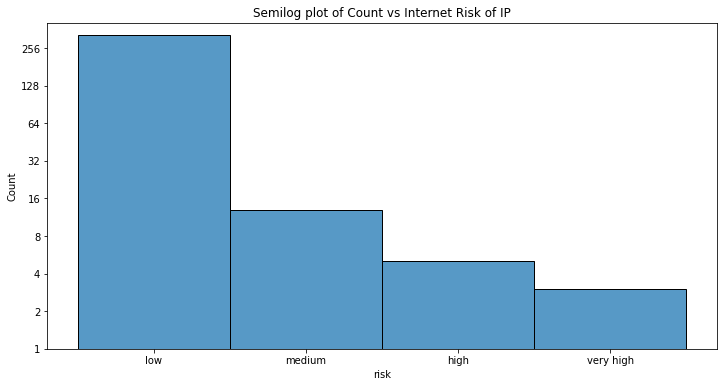

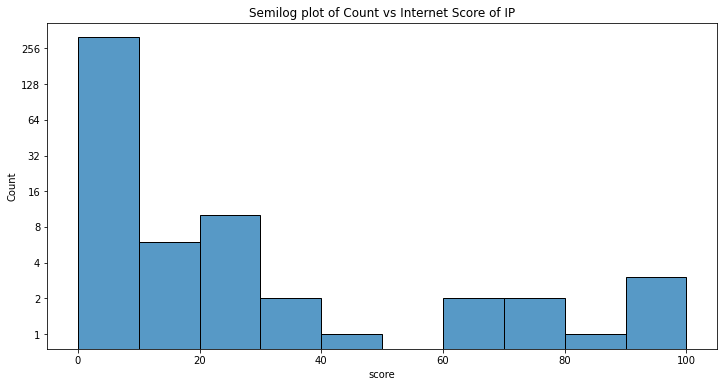

In [1]:
''' Draw histogram of counts vs risk for the ip addresses found
    in log4j hits as reported in Splunk.
    - Use the output of parse_ip_from_payload.py, log4j_hosts.csv
    - See plot_frequency_risky_ips.py
'''

# Import the modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import dmv_test.mywhois as mywhois
import ipaddress

def ip_only(hosts):
    ## ip_only(df): Return rows where ip is legitimate
    def is_ip(host):
        ## Test if ip address is proper
        try:
            ip_address = ipaddress.ip_address(host)
        except:
            return False
        return True
    return hosts[hosts["ip"].apply(is_ip)].copy()

def fscore(ip_string):
    ## fscore(ipstring): get internet risk score as integer
    r = whois.find(ip_string)
    return int(r["score"]) if r else -1 

def frisk(ip_string):
    ## frisk(ip_string): get internet risk 
    r = whois.find(ip_string)
    return r["risk"] if r else "Unknown"

def plot1(hosts):
    fig, ax = plt.subplots(figsize=(12,6))
    g = sns.histplot(data=hosts, x="risk", ax=ax)
    plt.semilogy(base=2)
    ticks = 2**np.arange(9)  # How do I get 9?
    plt.yticks(ticks, [ f"{x:.0f}" for x in ticks ])
    plt.title("Semilog plot of Count vs Internet Risk of IP")
    plt.show()

def plot2(hosts):
    fig, ax = plt.subplots(figsize=(12,6))
    g1 = sns.histplot(data=hosts, x="score", ax=ax, bins=10)
    plt.semilogy(base=2)
    ticks = 2**np.arange(9)  # How do I get 9?
    plt.yticks(ticks, [ f"{x:.0f}" for x in ticks ])
    plt.title("Semilog plot of Count vs Internet Score of IP")
    plt.show()


# Read in the data
fn =  "log4j_hosts.csv"

# Read the hosts found in the https jndi events returned by the splunk search
raw_hosts = pd.read_csv(fn)

# load the whois database - readonly
whois = mywhois.Risk("../dmv_test/mywhois", readonly=True)

# Clean list by dropping bad ip addresses (probably host names)
hosts = ip_only(raw_hosts)

# Add internet risk score and risk category
myscore = hosts.loc[:,"ip"].apply(fscore).copy()
myrisk  = hosts.loc[:,"ip"].apply(frisk).copy()

hosts.loc[:,"risk"]  = myrisk
hosts.loc[:,"score"] = myscore

# Make risk into a factor category
# See https://stackoverflow.com/questions/67205522/set-order-on-sns-histplot

hosts.risk = pd.Categorical(hosts.risk, ["Unknown", "low", "medium", "high", "very high"])

# Draw plots
plot1(hosts)

plot2(hosts)


In [14]:
%%python - -i all_jndi_payloads_2021.csv -o all_jndi_hits_2021.csv 
''' Parse base64 payloads of log4j jndi into readable payloads
    Option:
    -i <fn> Use file with columns host, time, payload
            eg. download all_jndi_payloads.csv ed from saved Splunk search
            > Otherwise, then run splunk search
    Output file has columns host, time, payload (readable)
    -o <fn> Use provided name for output
            > Otherwise write to search_log4j.csv
    --defang Defang the payload so the line don't execute
    See parse_raw_payload.py
'''

import base64
import csv
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import httplib2
import getpass
import sys
from time import sleep
import splunklib.results as results
import splunklib.client as client
import re

def defang_host(str):
    return re.sub(r"(https?:\/\/)([^\/]+)", r"\1?\2", str)

def defang_ip(str):
    return re.sub(r"((?:(?:[0-9]{1,3})(?:\.)?){4})", r"?\1", str)

def defang(str):
    fang = lambda p, s: re.sub(f"{p}", r"?\1", s)
    try:
        if type(str) == str:
            if len(str) == 0:
                return str
        if type(str) == float:
            if np.isnan(str):
                return str
        r = defang_ip( defang_host( fang("(wget|curl|bash|http)", str) ) )       
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        import pdb; pdb.set_trace()
    return r

def quote_words(str):
    '''quote_words("word1 word2") --> "word1",:word2
       Change string of words into string in quoted csv format
    '''
    return ",".join([ f'"{x}"' for x in str.replace("\n","").split()])

def build_query():
    # Build a query
    # Reminder: earliest_time = "12/13/2021:00:00:00"
    # Returns 
    
    earliest_time = "12/09/2021:00:00:00"
    latest_time ="12/31/2021:00:00:00"

    idx = """directory_services_nonprod doh_google_cloud dol_google_cloud dtf_http estreamer
    fireeye hcr_google_cloud health_datapower health_network its_google_cloud its_okta
    nonprod main miauditlogs os otda_google_cloud vmware webny webny_nonprod wineventlog"""

    indexes = f"index IN ({quote_words(idx)})"

    match = '''Base64 Command "${jndi:*}"'''

    rex = '''| rex max_match=5 
    "({jndi.*?Base64\/(?<b64>(?:[A-Za-z0-9+\/]{4})*(?:[A-Za-z0-9+\/]{2}==|[A-Za-z0-9+\/]{3}=)?))"'''

    stats = '''
    | mvexpand b64 | stats values(host) as host earliest(_time) as earliest by b64 |  mvexpand host 
    | convert timeformat="%m/%d/%Y %H:%M:%S" ctime(earliest) as time 
    | rename b64 as payload
    | sort host +time 
    | table host time payload'''

    query = f"""search earliest={earliest_time}
                latest={latest_time} 
                {indexes} {match} {rex} {stats}"""

    return query

def d64(x):
    ''' d(b64)-->decodes base64 byte string. =Nan if there's an error
    '''
    try:
        r = base64.b64decode(x, altchars="-_").decode()
    except:
        r = np.nan
    return r

def make_list(events):
    '''make_list(events)-->list of the splunk events
    ''' 
    lst = []
    for result in results.ResultsReader(events):
        lst.extend(result.values())
    return lst

def list_to_df(lst, columns):
    '''Create a df with n=len(columns) columns from alist
       0th row has items lst[0] lst[1] ... (n-1)th
       lst row has items lst[0+n] lst[1+n] ... lst[(n-1 + n)i
       ... etc
    '''
    num_columns = len(columns)
    len_list    = len(lst)
    
    # Make sure t
    if len_list % num_columns != 0:
        print(f"length of lst ({len_list}) must be even multiple of # of names ({num_columns})")
        return None
    
    # Reshape the list into a list of lists before returning the dataframe
    sublists = [ lst[i:i+num_columns] for i in range(0, len_list, num_columns) ]
    return pd.DataFrame(sublists, columns=columns)

def run_search():
    """ Return df with columns host, time and payload (base64) from splunk search"""
    def results_to_df(splunk_results):
        lst = make_list(save_results)
        log = list_to_df(lst, columns=["host", "time", "payload"])
        return log

    HOST = "cnsesplunkoperations.svc.ny.gov"
    PORT = 8089
    USERNAME = "bdk01"
#     PASSWORD = mygetpass()
    PASSWORD = "Xsw2chini,"
    OWNER = "bdk01"
    APP = "search"

    # Create a Service instance and log in 
    service = client.connect(
        host=HOST,
        port=PORT,
        username=USERNAME,
        password=PASSWORD,
        owner=OWNER,
        app=APP)

    kwargs_normalsearch = {
    #     "earliest_time": "12/09/2021:00:00:00",
    #     "latest_time": "-1d@d",
        "search_mode": "normal"
        }
    searchquery_normal = build_query()

    job = service.jobs.create(searchquery_normal, **kwargs_normalsearch)

    # A normal search returns the job's SID right away, so we need to poll for completion
    while True:
        while not job.is_ready():
            pass
        stats = {"isDone": job["isDone"],
                 "doneProgress": float(job["doneProgress"])*100,
                  "scanCount": int(job["scanCount"]),
                  "eventCount": int(job["eventCount"]),
                  "resultCount": int(job["resultCount"])}

        status = ("\r%(doneProgress)03.1f%%   %(scanCount)d scanned   "
                  "%(eventCount)d matched   %(resultCount)d results") % stats

        print(f"{status=}")
        sys.stdout.flush()
        if stats["isDone"] == "1":
            sys.stdout.write("\n\nDone!\n\n")
            break
        sleep(2)

    # By default only 100 events are returned. Use count=0 to get all of them to sys limit.
    # See: Splunk Answer 308505
    # https://community.splunk.com/t5/Splunk-Search/Custom-Splunk-search-command-only-returns-100-results/m-p/308505

    save_results = job.results(count=0)
    df = results_to_df(save_results)
    job.cancel()   
    return df

def defanger(log, defanging=False):
    log.columns = ["host", "time", "base64_payload"]
    if defanging:
        log["raw_payload"] = log.loc[:,"base64_payload"].apply(d64)
        # Defang the raw_payload column into new column, payload
        log["payload"] = log.loc[:,"raw_payload"].apply(defang)
    else:
        log["payload"] = log.loc[:,"base64_payload"].apply(d64)

def options(finput=None, foutput=None, defanging=False):
    Usage = "parse_raw_payload [-i <finput>] [-o <foutput>] [--defang]"
    defanging = False
    foutput = "search_log4j.csv"
    args = (x for x in sys.argv)
#     args = (x for x in "-i all_jndi_payloads_2021.csv -o all_jndi_hits_2021.csv".split())
    for arg in args:
        if arg=="-i":
            try:
                finput = next(args)
            except:
                sys.exit(f"{Usage=}")
        if arg == "-o":
            try:
                foutput = next(args)
            except:
                sys.exit(f"{Usage=}")
        if arg == "--defang":
            defanging = True
    return finput, foutput, defanging

def main():
    finput, foutput, defanging = options()
    if finput is None:
        log = run_search()
    else:
        log = pd.read_csv(finput)

    defanger(log, defanging=defanging)
    
    log[["host", "time", "payload"]].to_csv(foutput, index=False)

main()

In [15]:
import getpass
import splunklib.client as client
def login():
    HOST = "cnsesplunkoperations.svc.ny.gov"
    PORT = 8089
    USERNAME = "bdk01"
    PASSWORD = getpass.getpass()
    OWNER = "bdk01"
    APP = "search"

    # Create a Service instance and log in 
    service = client.connect(
        host=HOST,
        port=PORT,
        username=USERNAME,
        password=PASSWORD,
        owner=OWNER,
        app=APP)

def main():
    login()
    
main()

········


In [20]:
# Main program to fetch Splunk sid, sessionKey

import getpass
import urllib.request, urllib.parse, urllib.error
import httplib2
from xml.dom import minidom

baseurl = "https://its824pl5spldp.svc.ny.gov:8089"
username = "bdk01"
password = getpass.getpass()

searchQuery = "search index=main sourcetype=cisco:ios | head 5"

# Authenticate with server.
# It is necessary to disable SSL cert validation. Splunk certs are self-signed.
# The followng will not work
# serverContent = httplib2.Http().request(baseurl + "/services/auth/login",

serverContent = httplib2.Http(disable_ssl_certificate_validation=True).request(baseurl + "/services/auth/login",
    "POST", headers={}, body=urllib.parse.urlencode({"username":username, "password":password}))[1]

sessionKey = minidom.parseString(serverContent).getElementsByTagName("sessionKey")[0].childNodes[0].nodeValue

········
